## Titanic dataset

In [128]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from neural_network import Network
from activations import Tanh, Sigmoid, ReLU, LeakyReLU
from layers import ActivationLayer, FCLayer
from losses import MSE

np.random.seed(7)

feature_names = ['Sex', 'Age', 'SibSp', 'Pclass', 'Parch', 'Fare', 'Embarked']
target_name = 'Survived'

dataset = pd.read_csv("train.csv")
dataset.head()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [129]:
from sklearn.model_selection import train_test_split


dataset = dataset[feature_names + [target_name]].dropna()

X = dataset[feature_names]
y = dataset[[target_name]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=7)

In [130]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
    )

encoder = OrdinalEncoder()
X_train['Sex'] = encoder.fit_transform(X_train[['Sex']])
X_test['Sex'] = encoder.transform(X_test[['Sex']])

encoder = OrdinalEncoder()
X_train['Embarked'] = encoder.fit_transform(X_train[['Embarked']])
X_test['Embarked'] = encoder.transform(X_test[['Embarked']])


scaler = StandardScaler()
X_train = X_train.values
X_test = X_test.values
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((569, 7), (569, 1), (143, 7), (143, 1))

In [131]:
from sklearn.preprocessing import scale

scale([[0, 50, 0.3, 5], [1, 30, 0.2, 3], [0, 20, 0.2, 2]])

array([[-0.70710678,  1.33630621,  1.41421356,  1.33630621],
       [ 1.41421356, -0.26726124, -0.70710678, -0.26726124],
       [-0.70710678, -1.06904497, -0.70710678, -1.06904497]])

In [132]:
X_train = X_train.reshape((569, 1, 7))
y_train = y_train.values.reshape((569, 1, 1))

# Only for tanh
# How would this encoding change if you use sigmoid in the last layer?
y_train[y_train == 1] = 1
y_train[y_train == 0] = -1


X_test = X_test.reshape((143, 1, 7))
y_test = y_test.values.reshape((143, 1, 1))

# Only for tanh
# How would this encoding change if you use sigmoid in the last layer?
y_test[y_test == 1] = 1
y_test[y_test == 0] = -1

## Network modeling with Tanh

In [133]:
net = Network()

net.add(FCLayer(7, 70))
net.add(ActivationLayer(Tanh()))
net.add(FCLayer(70, 50))
net.add(ActivationLayer(Tanh()))
net.add(FCLayer(50, 30))
net.add(ActivationLayer(Tanh()))
net.add(FCLayer(30, 20))
net.add(ActivationLayer(Tanh()))
net.add(FCLayer(20, 5))
net.add(ActivationLayer(Tanh()))
net.add(FCLayer(5, 2))
net.add(ActivationLayer(Tanh()))

net.use(MSE())
net.fit(X_train, y_train, epochs=1000, learning_rate=0.001)

Epoch: 999 | Train loss: 0.1737: 100%|██████████| 1000/1000 [01:15<00:00, 13.29it/s]


Text(0, 0.5, 'Loss')

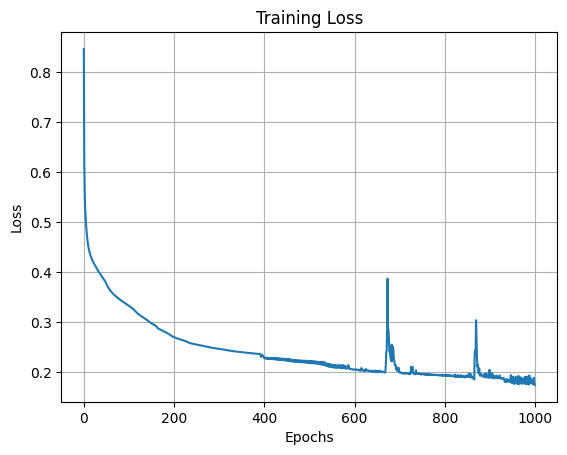

In [134]:
import matplotlib.pyplot as plt

plt.plot(range(1000), net.err_log)
plt.grid(True)
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

[[74 11]
 [15 43]]


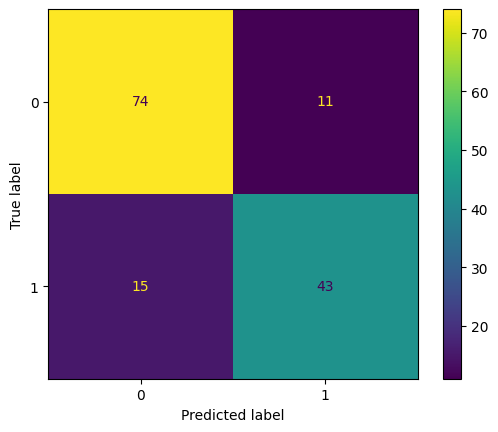

In [135]:
# How would this threshold change if you use sigmoid in the last layer?
threshold = 0

y_pred = net.predict(X_test)
y_pred = [1 if p[0][0] >= threshold else 0 for p in y_pred]
y_true = [1 if p[0][0] >= threshold else 0 for p in y_test]
print(confusion_matrix(y_true, y_pred))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred);

In [136]:
print(classification_report(y_pred, y_true, zero_division=0))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85        89
           1       0.74      0.80      0.77        54

    accuracy                           0.82       143
   macro avg       0.81      0.81      0.81       143
weighted avg       0.82      0.82      0.82       143



In [137]:
cm = np.zeros((2, 2))
for i in range(len(y_true)):
    if y_true[i] == 0 and y_pred[i] == 0:
        cm[0, 0] += 1
    elif y_true[i] == 1 and y_pred[i] == 1:
        cm[1, 1] += 1
    elif y_true[i] == 0 and y_pred[i] == 1:
        cm[0, 1] += 1
    elif y_true[i] == 1 and y_pred[i] == 0:
        cm[1, 0] += 1


In [138]:
def my_accuracy(y_true, y_pred):
    return (cm[0, 0]+cm[1, 1])/cm.sum()


def my_precision(y_true, y_pred):
    return cm[1, 1]/(cm[1, 1]+cm[0, 1])


def my_recall(y_true, y_pred):
    return cm[1, 1]/(cm[1, 1]+cm[1, 0])

def my_confusion_matrix(y_true, y_pred):
    return cm


# See what average="binary" means in sklearn documentation
assert my_accuracy(y_true, y_pred) == accuracy_score(y_true, y_pred)
assert my_recall(y_true, y_pred) == recall_score(
    y_true, y_pred, average='binary')
assert my_precision(y_true, y_pred) == precision_score(
    y_true, y_pred, average='binary')
assert (my_confusion_matrix(y_true, y_pred) == my_confusion_matrix(y_true, y_pred)).all()


## Network modeling with Sigmoid

In [139]:
net = Network()

net.add(FCLayer(7, 10))
net.add(ActivationLayer(Sigmoid()))
net.add(FCLayer(10, 20))
net.add(ActivationLayer(Sigmoid()))
net.add(FCLayer(20, 50))
net.add(ActivationLayer(Sigmoid()))
net.add(FCLayer(50, 20))
net.add(ActivationLayer(Sigmoid()))
net.add(FCLayer(20, 10))
net.add(ActivationLayer(Sigmoid()))
net.add(FCLayer(10, 1))
net.add(ActivationLayer(Sigmoid()))

net.use(MSE())
net.fit(X_train, y_train, epochs=500, learning_rate=0.001)


Epoch: 499 | Train loss: 1.001: 100%|██████████| 500/500 [00:47<00:00, 10.55it/s]


[[ 0 85]
 [ 0 58]]


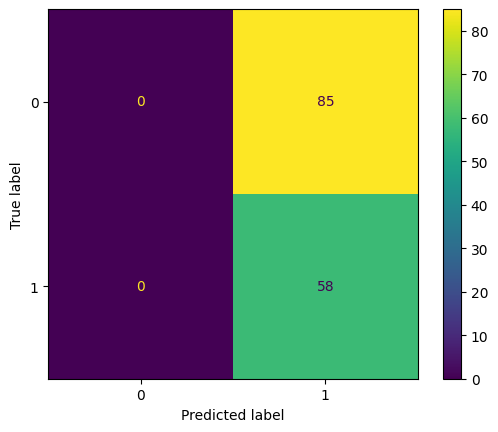

In [140]:
# How would this threshold change if you use sigmoid in the last layer?
threshold = 0

y_pred_2 = net.predict(X_test)
y_pred_2 = [1 if p[0][0] >= threshold else 0 for p in y_pred_2]
y_true_2 = [1 if p[0][0] >= threshold else 0 for p in y_test]
print(confusion_matrix(y_true_2, y_pred_2))
ConfusionMatrixDisplay.from_predictions(y_true_2, y_pred_2)


In [141]:
cm_2 = np.zeros((2, 2))
for i in range(len(y_true_2)):
    if y_true_2[i] == 0 and y_pred_2[i] == 0:
        cm_2[0, 0] += 1
    elif y_true_2[i] == 1 and y_pred_2[i] == 1:
        cm_2[1, 1] += 1
    elif y_true_2[i] == 0 and y_pred_2[i] == 1:
        cm_2[0, 1] += 1
    elif y_true_2[i] == 1 and y_pred_2[i] == 0:
        cm_2[1, 0] += 1


In [142]:
def my_accuracy_2(y_true_2, y_pred_2):
    return (cm_2[0, 0]+cm_2[1, 1])/cm_2.sum()


def my_precision_2(y_true_2, y_pred_2):
    return cm_2[1, 1]/(cm_2[1, 1]+cm_2[0, 1])


def my_recall_2(y_true_2, y_pred_2):
    return cm_2[1, 1]/(cm_2[1, 1]+cm_2[1, 0])


def my_confusion_matrix(y_true_2, y_pred_2):
    return cm_2


# See what average="binary" means in sklearn documentation
assert my_accuracy_2(y_true_2, y_pred_2) == accuracy_score(y_true_2, y_pred_2)
assert my_recall_2(y_true_2, y_pred_2) == recall_score(
    y_true_2, y_pred_2, average='binary')
assert my_precision_2(y_true_2, y_pred_2) == precision_score(
    y_true_2, y_pred_2, average='binary')
assert (my_confusion_matrix(y_true_2, y_pred_2) ==my_confusion_matrix(y_true_2, y_pred_2)).all()


## Network modeling with ReLU

In [143]:
net = Network()

net.add(FCLayer(7, 10))
net.add(ActivationLayer(ReLU()))
net.add(FCLayer(10, 20))
net.add(ActivationLayer(ReLU()))
net.add(FCLayer(20, 50))
net.add(ActivationLayer(ReLU()))
net.add(FCLayer(50, 20))
net.add(ActivationLayer(ReLU()))
net.add(FCLayer(20, 10))
net.add(ActivationLayer(ReLU()))
net.add(FCLayer(10, 1))
net.add(ActivationLayer(ReLU()))

net.use(MSE())
net.fit(X_train, y_train, epochs=500, learning_rate=0.001)


Epoch: 499 | Train loss: 1.0: 100%|██████████| 500/500 [00:41<00:00, 12.03it/s]


[[ 0 85]
 [ 0 58]]


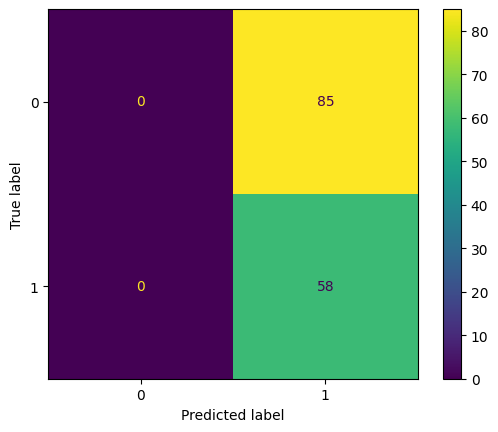

In [144]:
# How would this threshold change if you use sigmoid in the last layer?
threshold = 0

y_pred_3 = net.predict(X_test)
y_pred_3 = [1 if p[0][0] >= threshold else 0 for p in y_pred_3]
y_true_3 = [1 if p[0][0] >= threshold else 0 for p in y_test]
print(confusion_matrix(y_true_3, y_pred_3))
ConfusionMatrixDisplay.from_predictions(y_true_3, y_pred_3)


In [145]:
cm_3 = np.zeros((2, 2))
for i in range(len(y_true_3)):
    if y_true_3[i] == 0 and y_pred_3[i] == 0:
        cm_3[0, 0] += 1
    elif y_true_3[i] == 1 and y_pred_3[i] == 1:
        cm_3[1, 1] += 1
    elif y_true_3[i] == 0 and y_pred_3[i] == 1:
        cm_3[0, 1] += 1
    elif y_true_3[i] == 1 and y_pred_3[i] == 0:
        cm_3[1, 0] += 1


In [146]:
def my_accuracy_3(y_true_3, y_pred_3):
    return (cm_3[0, 0]+cm_3[1, 1])/cm_3.sum()


def my_precision_3(y_true_3, y_pred_3):
    return cm_3[1, 1]/(cm_3[1, 1]+cm_3[0, 1])


def my_recall_3(y_true_3, y_pred_3):
    return cm_3[1, 1]/(cm_3[1, 1]+cm_3[1, 0])


def my_confusion_matrix(y_true_3, y_pred_3):
    return cm_3


# See what average="binary" means in sklearn documentation
assert my_accuracy_3(y_true_3, y_pred_3) == accuracy_score(y_true_3, y_pred_3)
assert my_recall_3(y_true_3, y_pred_3) == recall_score(
    y_true_3, y_pred_3, average='binary')
assert my_precision_3(y_true_3, y_pred_3) == precision_score(
    y_true_3, y_pred_3, average='binary')
assert (my_confusion_matrix(y_true_3, y_pred_3) ==
        my_confusion_matrix(y_true_3, y_pred_3)).all()


## Network modeling with LeaklyReLU

In [152]:
net = Network()

net.add(FCLayer(7, 70))
net.add(ActivationLayer(LeakyReLU()))
net.add(FCLayer(70, 40))
net.add(ActivationLayer(LeakyReLU()))
net.add(FCLayer(40, 50))
net.add(ActivationLayer(LeakyReLU()))
net.add(FCLayer(50, 20))
net.add(ActivationLayer(LeakyReLU()))
net.add(FCLayer(20, 10))
net.add(ActivationLayer(LeakyReLU()))
net.add(FCLayer(10, 2))
net.add(ActivationLayer(LeakyReLU()))

net.use(MSE())
net.fit(X_train, y_train, epochs=500, learning_rate=0.001)


Epoch: 499 | Train loss: 0.307: 100%|██████████| 500/500 [00:49<00:00, 10.00it/s] 


[[71 14]
 [13 45]]


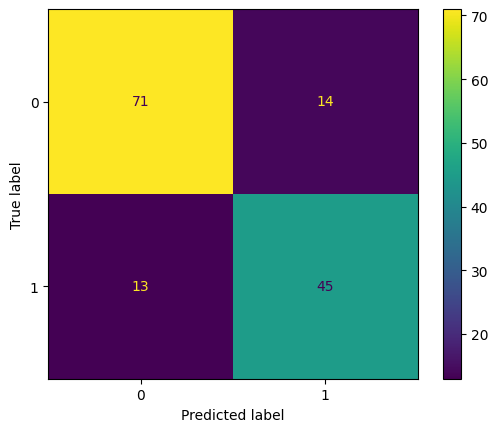

In [153]:
# How would this threshold change if you use sigmoid in the last layer?
threshold = 0

y_pred_4 = net.predict(X_test)
y_pred_4 = [1 if p[0][0] >= threshold else 0 for p in y_pred_4]
y_true_4 = [1 if p[0][0] >= threshold else 0 for p in y_test]
print(confusion_matrix(y_true_4, y_pred_4))
ConfusionMatrixDisplay.from_predictions(y_true_4, y_pred_4)


In [154]:
cm_4 = np.zeros((2, 2))
for i in range(len(y_true_3)):
    if y_true_4[i] == 0 and y_pred_4[i] == 0:
        cm_4[0, 0] += 1
    elif y_true_4[i] == 1 and y_pred_4[i] == 1:
        cm_4[1, 1] += 1
    elif y_true_4[i] == 0 and y_pred_4[i] == 1:
        cm_4[0, 1] += 1
    elif y_true_4[i] == 1 and y_pred_4[i] == 0:
        cm_4[1, 0] += 1


In [155]:
def my_accuracy_4(y_true_4, y_pred_4):
    return (cm_4[0, 0]+cm_4[1, 1])/cm_4.sum()


def my_precision_4(y_true_4, y_pred_4):
    return cm_4[1, 1]/(cm_4[1, 1]+cm_4[0, 1])


def my_recall_4(y_true_4, y_pred_4):
    return cm_4[1, 1]/(cm_4[1, 1]+cm_4[1, 0])


def my_confusion_matrix_4(y_true_4, y_pred_4):
    return cm_4


# See what average="binary" means in sklearn documentation
assert my_accuracy_4(y_true_4, y_pred_4) == accuracy_score(y_true_4, y_pred_4)
assert my_recall_4(y_true_4, y_pred_4) == recall_score(
    y_true_4, y_pred_4, average='binary')
assert my_precision_4(y_true_4, y_pred_4) == precision_score(
    y_true_4, y_pred_4, average='binary')
assert (my_confusion_matrix(y_true_4, y_pred_4) ==my_confusion_matrix(y_true_4, y_pred_4)).all()


# Conculison

* LeaklyReLU and Tanh are same.
* Sigmoid and ReLU are the worst.

In [156]:
print(f'Tanh - Accuracy:{my_accuracy(y_true, y_pred)} - Recall:{my_recall(y_true, y_pred)} - Prediction:{my_precision(y_true, y_pred)}\n')
print(f'Sigmoid - Accuracy:{my_accuracy_2(y_true_2, y_pred_2)} - Recall:{my_recall_2(y_true_2, y_pred_2)} - Prediction:{my_precision_2(y_true_2, y_pred_2)}\n')
print(f'ReLU - Accuracy:{my_accuracy_3(y_true_3, y_pred_3)} - Recall:{my_recall_3(y_true_3, y_pred_3)} - Prediction:{my_precision_3(y_true_3, y_pred_3)}\n')
print(f'LeaklyReLU - Accuracy:{my_accuracy_4(y_true_4, y_pred_4)} - Recall:{my_recall_4(y_true_4, y_pred_4)} - Prediction:{my_precision_4(y_true_4, y_pred_4)}\n')

Tanh - Accuracy:0.8181818181818182 - Recall:0.7413793103448276 - Prediction:0.7962962962962963

Sigmoid - Accuracy:0.40559440559440557 - Recall:1.0 - Prediction:0.40559440559440557

ReLU - Accuracy:0.40559440559440557 - Recall:1.0 - Prediction:0.40559440559440557

LeaklyReLU - Accuracy:0.8111888111888111 - Recall:0.7758620689655172 - Prediction:0.7627118644067796

